In [1]:
library(hdf5r)
library(Seurat)
library(purrr)
library(dplyr)
library(stringr)
library(harmony)
library(DoubletFinder)
library(ggplot2)
library(ggpubr)
library(plyr)
library(pheatmap)

Attaching SeuratObject


载入程辑包：‘purrr’


The following object is masked from ‘package:hdf5r’:

    flatten_df



载入程辑包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


载入需要的程辑包：Rcpp

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


载入程辑包：‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




In [2]:
nk = readRDS('~/HPV/res/public_rna/seurat_rds/nk.rds')

In [3]:
# 进行筛选去除CD3表达的细胞
nk = nk[,which(colSums(nk[c('CD3D','CD3E','CD3G'),])==0)]
dim(nk)

[1] 19039  2012

In [4]:
# marker_genes = c('FCGR3A','GNLY','NKG7','GZMB','PRF1','NCAM1','TCF7','GZMK','XCL1','IL7R','GRN','RARG','NCR1','IFNG','TBX21','GATA3','RORC','NRP1','RGS1','MKI67')
marker_genes = c('FCGR3A','GNLY','NKG7','GZMB','PRF1','TCF7','GZMK','IL7R','RGS1','MKI67')

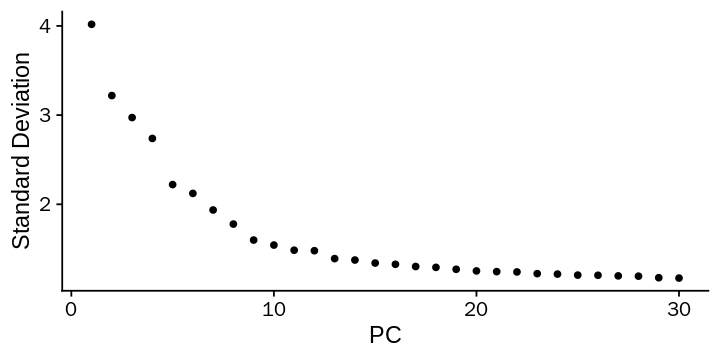

In [5]:
temp = nk
nk = CreateSeuratObject(counts = nk@assays$RNA@counts, project = "nk") %>% 
    NormalizeData(verbose = FALSE) %>%
    FindVariableFeatures(selection.method = "vst", nfeatures = 250)
VariableFeatures(nk) = unique(c(marker_genes, nk@assays$RNA@var.features))
nk = ScaleData(nk, verbose = FALSE) %>% 
    RunPCA(npcs = 30, verbose = FALSE)
options(repr.plot.width = 6, repr.plot.height = 3)
ElbowPlot(nk,ndims = 30)

In [6]:
nk@meta.data = temp@meta.data
nk = RunHarmony(nk, 'Patient', verbose = FALSE) %>%    
    RunUMAP(reduction = "harmony", dims = 1:15, verbose = FALSE) %>%
    FindNeighbors(reduction = "harmony", dims = 1:15, verbose = FALSE) %>%
    FindClusters(resolution = 0.6, verbose = FALSE)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


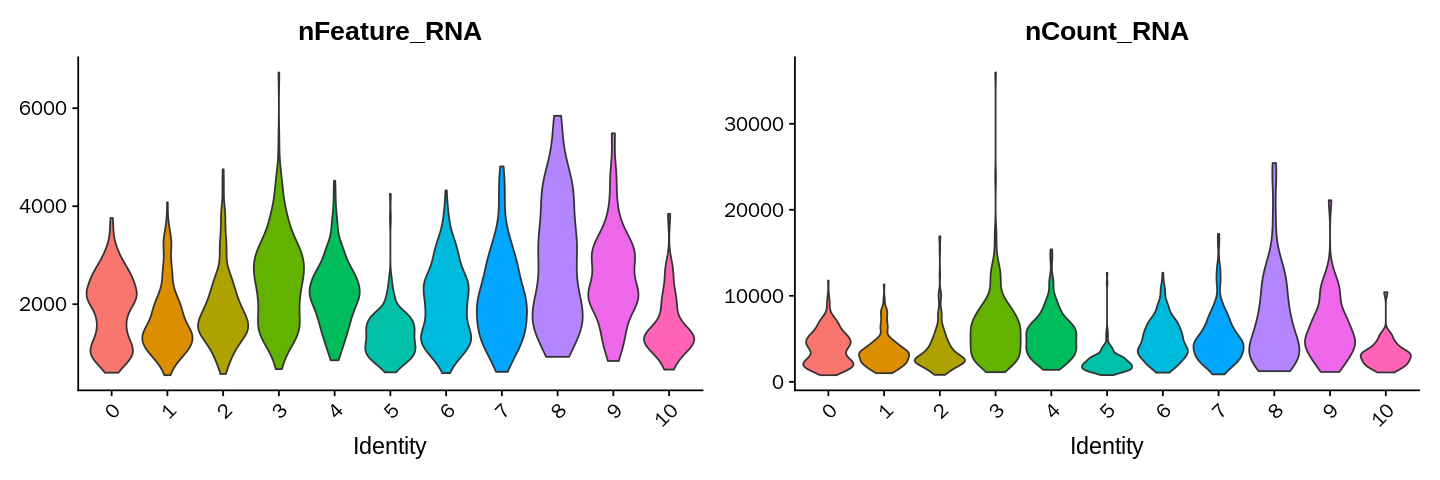

In [7]:
options(repr.plot.width = 12, repr.plot.height = 4)
VlnPlot(nk,features = c("nFeature_RNA", "nCount_RNA"),pt.size = 0)

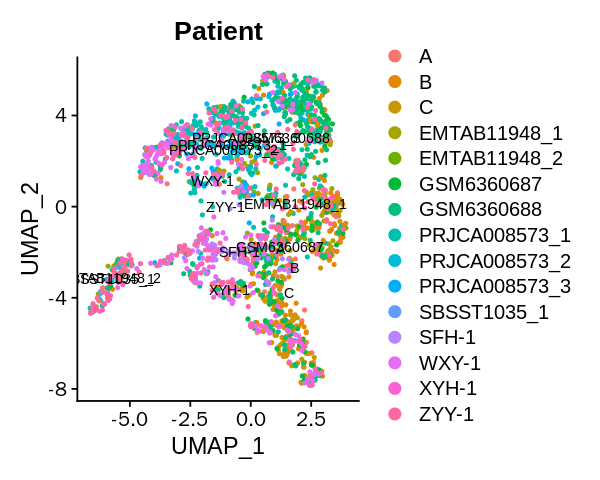

In [8]:
options(repr.plot.width = 5, repr.plot.height = 4)
DimPlot(nk, group.by = 'Patient',label = TRUE,label.size = 3)

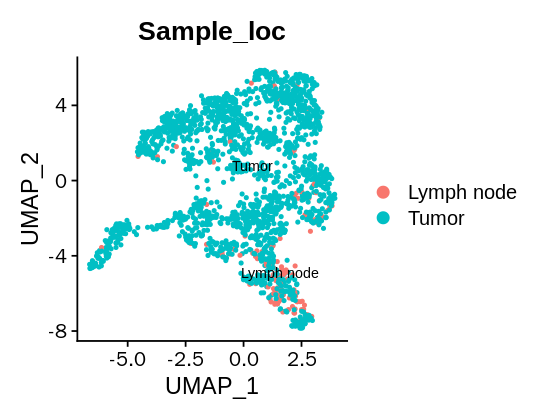

In [9]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(nk, group.by = 'Sample_loc',label = TRUE,label.size = 3)

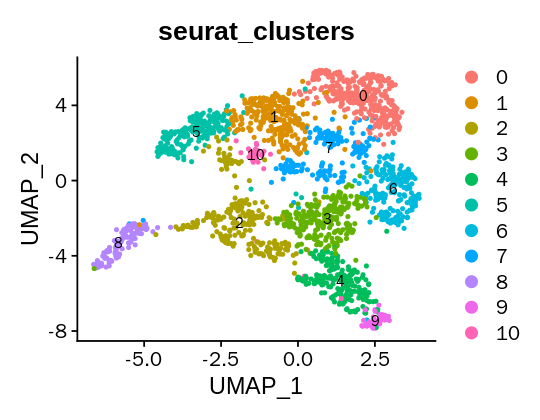

In [10]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(nk, group.by = 'seurat_clusters',label = TRUE,label.size = 3)

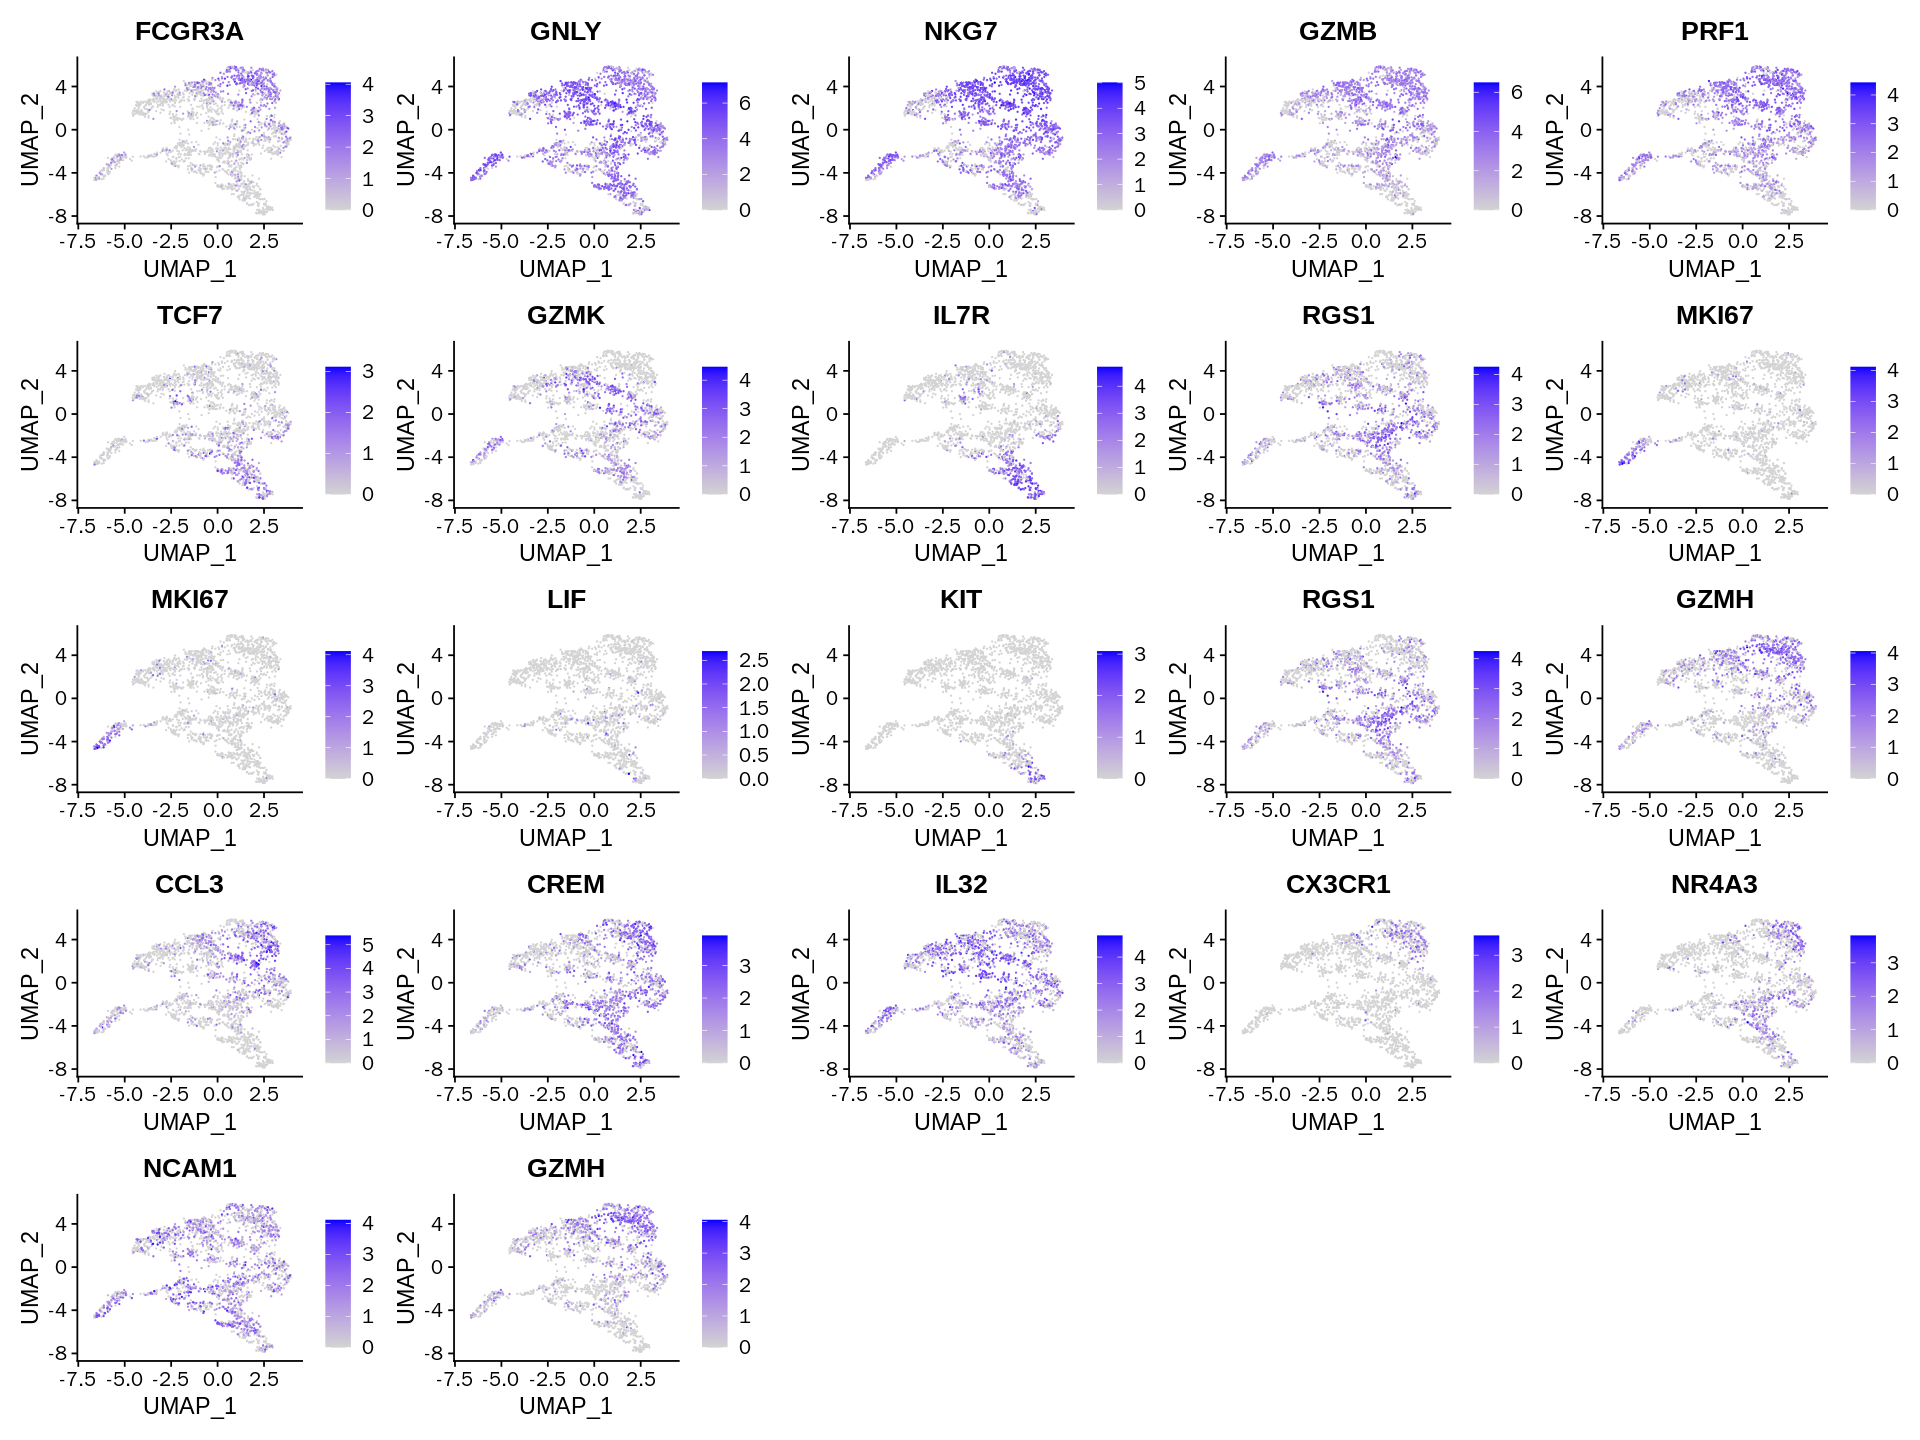

In [11]:
options(repr.plot.width = 16, repr.plot.height = 12)
FeaturePlot(nk,features = c(marker_genes,'MKI67','LIF','KIT','RGS1','GZMH','CCL3','CREM','IL32','CX3CR1','NR4A3','NCAM1','GZMH'),ncol = 5,pt.size = 0.001)

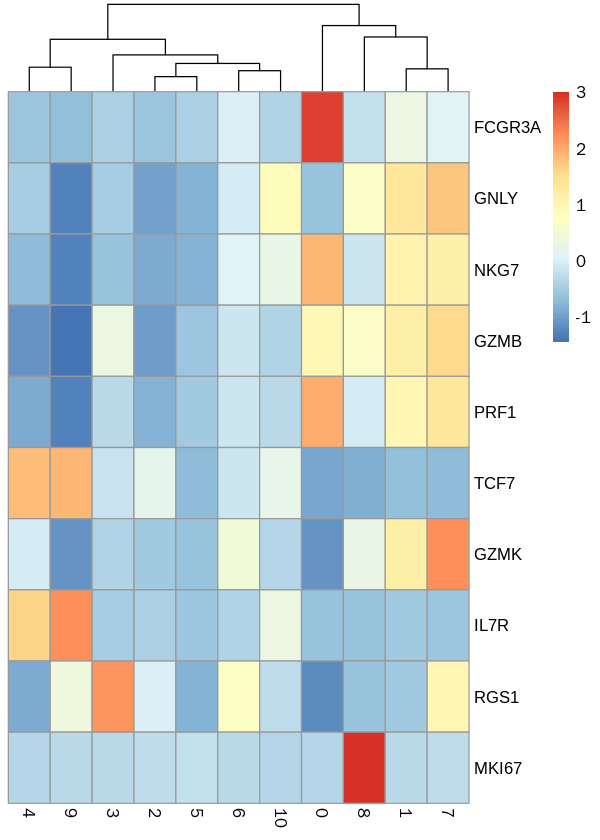

In [12]:
gene_cell_exp <- AverageExpression(nk,
                                   features = c(marker_genes,'RGS1'),
                                   group.by = 'seurat_clusters',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))
options(repr.plot.width = 5, repr.plot.height = 7)
pheatmap(marker_exp,cluster_rows = FALSE)

In [13]:
low_res = FindClusters(nk, resolution = 0.4, verbose = FALSE)

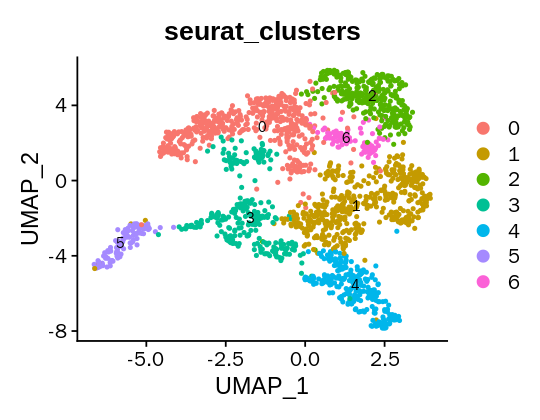

In [14]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(low_res, group.by = 'seurat_clusters',label = TRUE,label.size = 3)

In [15]:
nk$minor = 'temp'
nk$minor[nk$seurat_clusters %in% c('9')] = 'ILC3'
nk$minor[nk$seurat_clusters %in% c('0')] = 'NKCD16'
nk$minor[nk$seurat_clusters %in% c('8')] = 'NKcc'
nk$minor[nk$seurat_clusters %in% c('4')] = 'NKCD56_1'
nk$minor[nk$seurat_clusters %in% c('3','6')] = 'NKCD56_2'
nk$minor[nk$seurat_clusters %in% c('1','7','5')] = 'NKCD56_3'
nk$minor[nk$seurat_clusters %in% c('2','10')] = 'NKCD56_4'

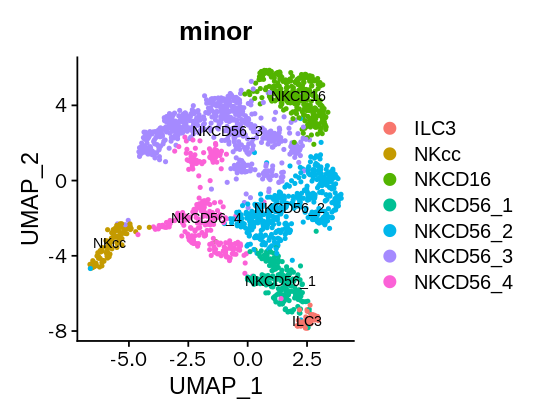

In [16]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(nk, group.by = 'minor',label = TRUE,label.size = 3)

In [17]:
saveRDS(nk,file = '~/HPV/res/public_rna/seurat_rds/nk.rds')